# Принятие решений в бизнесе на основе данных: как увеличить выручку интеренет-магазина

## Цель исследования

Отдел маркетинга крупного интеренет-магазина подготовил список гипотез для увеличения выручки. 

Задача: 
- приоретизировать гипотезы, 
- запустить А/В-тест, 
- проанализировать результаты.

## Знакомство с данными

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import datetime as dt
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 110

### Загрузка данных

In [2]:
hypothesis = pd.read_csv('hypothesis.csv') # список гипотез
orders = pd.read_csv('orders.csv') # данные о заказах
visitors = pd.read_csv('visitors.csv') # данные о посещениях сайта

display('hypothesis', hypothesis.head(3), hypothesis.shape)
display('orders', orders.head(3), orders.shape)
display('visitors', visitors.head(3), visitors.shape)


'hypothesis'

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


(9, 5)

'orders'

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


(1197, 5)

'visitors'

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


(62, 3)

### Вывод

<p></p>

<div style="border:solid green 2px; padding: 20px">
Для дальнейшей работы имеем 3 таблицы:          
    
**hypothesis** - список из 9 гипотез, где
- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. 
    
**orders** - данные о 1197 заказах, где
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.
    
**visitors** - данные о посещениях сайта, где    
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста    
 
</div>

## Предобработка данных

### Переименование столбцов

Приведем название столбцов к змеиному регистру для удобства и красоты:

In [3]:
hypothesis.columns = [col.lower() for col in hypothesis.columns]
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

### Проверка типов данных и пропусков

In [4]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков не обнаружено.

Для удобства работы с датами преобразуем их в соответствующий тип:

In [7]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Проверка дубликатов

In [8]:
print(hypothesis.duplicated().sum(), orders.duplicated().sum(), visitors.duplicated().sum())

0 0 0


Дубликатов нет.

### Количество пользователей

Проверим, сколько пользователей у нас в каждой группе и нет ли пересечений (тех, кто попал в обе группы):

In [9]:
display(orders.groupby('group')['visitor_id'].nunique())
print('Всего уникальных пользователей:', orders.visitor_id.nunique())
print('Сумма пользователей групп А и В:', orders.groupby('group')['visitor_id'].nunique().sum())

group
A    503
B    586
Name: visitor_id, dtype: int64

Всего уникальных пользователей: 1031
Сумма пользователей групп А и В: 1089


Всего у нас 1031 пользователь. Группы А и В сопоставимы по размерам и достаточно велики. 

Однако 58 пользователей попали в обе группы, их следовало бы исключить из анализа. Мы спокойно могли бы удалить их из таблицы orders. Могли бы также вычислить, в какие дни они оформляли заказы и эти посещения вычесть из количества визитов в таблице visitors. Но мы никак не вычислим, сколько раз и когда они заходили на сайт "просто посмотреть" (у нас в таблице visitors данные обезличены). В результате удаление таких пользователей исказит нам конверсию. Поэтому оставим, как есть, их доля не так уж и велика и составляет 5,6%. Но обратим внимание маркетингового отдела на эту ошибку.

### Исследуемый период

Проверим соответствие периодов в таблицах с заказами и посещениями сайта:

In [10]:
print('Период в таблице с заказами: с {} по {}'.format(orders['date'].min(), orders['date'].max()))
print('Период в таблице с визитами: с {} по {}'.format(visitors['date'].min(), visitors['date'].max()))


Период в таблице с заказами: с 2019-08-01 00:00:00 по 2019-08-31 00:00:00
Период в таблице с визитами: с 2019-08-01 00:00:00 по 2019-08-31 00:00:00


Исследуемый период - с 1 по 31 августа 2019 года.

### Количество заказов

Проверим, как распределено количество заказов:

In [11]:
orders_by_users = orders.groupby('visitor_id', as_index=False).agg({'transaction_id':'nunique'})
orders_by_users.columns = ['visitor_id', 'orders_count']
orders_by_users.sort_values(by='orders_count', ascending=False).head()

,visitor_id,orders_count
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


In [12]:
orders_by_users['orders_count'].describe()

count    1031.000000
mean        1.161009
std         0.724919
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        11.000000
Name: orders_count, dtype: float64

Количество покупателей - 1031, минимальное количество заказов за месяц - 1, среднее - 1, максимальное - 11. Имеем пик в районе 1 и длинный хвост справа, т.е. распределение не похоже на нормальное.

Проверим нормальность распределения заказов методом Шапиро_Уилка.<a id='orders'></a>

**Нулевая гипотеза**: Распределение является нормальным.

**Альтернативная гипотеза**: Распределение не является нормальным.

In [13]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(orders_by_users['orders_count'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Оценим визуально границу хвоста с аномалиями. Для этого построим точечную диаграмму числа заказов на одного пользователя:

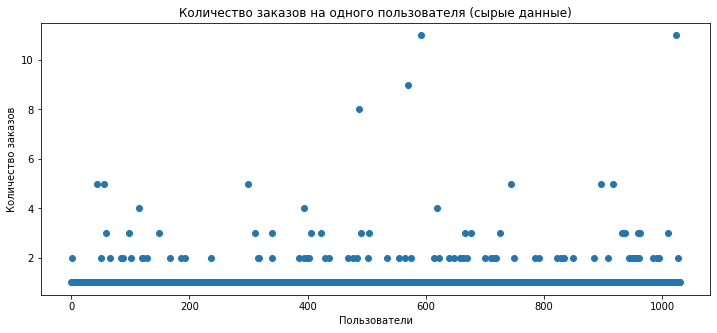

In [14]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure(figsize=(12,5))
plt.scatter(x_values, orders_by_users['orders_count'])
plt.title('Количество заказов на одного пользователя (сырые данные)')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Большинство пользователей сделали за месяц 1-2 заказа. Граница для отсечения выбросов будет где-то в районе 3-4 заказов. 

Чтобы выбрать границу, посчитаем 95-ый и 99-ый персентили: <a id='orders_pers'></a>

In [15]:
np.percentile(orders_by_users['orders_count'], [95, 99])

array([2., 4.])

Более 2-х заказов (т.е. от 3-х) оформили 5% пользователей. Более 4-х заказов (т.е. от 5-и) - 1% пользователей. 

Будем считать аномальными пользователей, сделавших 5 заказов и более.

### Стоимость заказов

Теперь изучим стоимость заказов:

In [16]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Всего у нас 1 197 заказов, минимальная стоимость - 50 у.е., медианная - 2 978 у.е., средняя - 8 348 у.е., максимальная - 1,3 млн. у.е. Распределение также не похоже на нормальное и сильно скошено вправо.

Проверим нормальность распределения заказов методом Шапиро_Уилка.<a id='revenue'></a>

**Нулевая гипотеза**: Распределение является нормальным.

**Альтернативная гипотеза**: Распределение не является нормальным.

In [17]:
alpha = 0.05  # критический уровень статистической значимости

results = st.shapiro(orders['revenue'])
p_value = results[1]  # второе значение в массиве результатов (с индексом 1) - p-value

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, всё нормально')

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


Построим точечную диаграмму, чтобы визуально оценить границу выбросов:

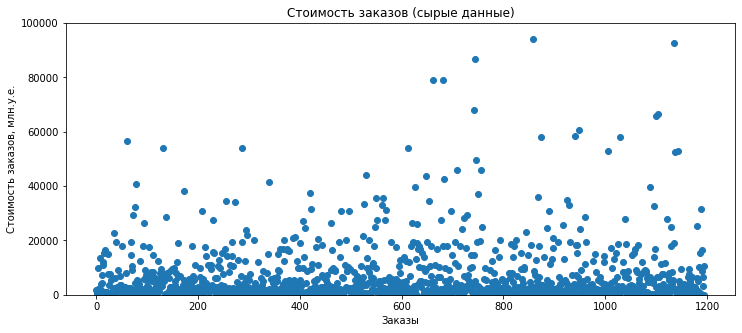

In [18]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(12,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов (сырые данные)')
plt.xlabel('Заказы')
plt.ylabel('Стоимость заказов, млн.у.е.')
plt.ylim(0,100000)
plt.show()

Здесь граница отсечения выбросов будет где-то между 20 и 40 тыс. у.е. Расчитаем 95-ый и 99-ый персентили: <a id='revenue_pers'></a>

In [19]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

У 5% заказов стоимость более 28 000 у.е. У 1% заказов стоимость более 58 233 у.е.

Будем считать аномалиями заказы стоимостью свыше 30 000 у.е.

### Вывод

<p></p>

<div style="border:solid green 2px; padding: 20px">
    
    
В ходе предобработки данных мы переименовали столбцы (привели их к змеиному регистру) и перевели даты в соответствующий формат. 
    
   
Также мы выяснили, что будем анализировать поведение 1031 пользователя в августе 2019 года.   
При этом 5,6% пользователей (58 чел.) попали одновременно в обе группы, что является ошибкой и недопустимо в будущем. В текущем исследовании мы исключить их не можем, т.к. не располагаем персонализированными данными о визитах.
    
Количество заказов и стоимость заказов распределены ненормально, в данных есть аномальные значения, поэтому для анализа статистической значимости будем в дальнейшем использовать критерий Манна-Уитни.    

    
За исследуемый период пользователи успели сделать от 1 до 11 заказов. Аномальными будем считать 1% покупателей, сделавших 5 и более заказов.
    
Стоимость заказов варьируется от 50 у.е. до 1,3 млн. у.е. Аномальными будем считать заказы стоимостью более 30 тыс. у.е. (это чуть менее 5% заказов).
    
Статистики в дальнейшем рассчитаем как для сырых, так и для очищенных от выбросов данных, чтобы понять, как аномалии влияют на показатели.
 
</div>

## Приоритизация гипотез

Изучим список гипотез и приоритезируем их:

In [20]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Приоритизация гипотез методом ICE

Формула для приоретизации методом ICE выглядит следующим образом:

$$ICE  score = \frac{Impact * Confidence}{Efforts}$$

In [21]:
hypothesis['ice_score'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'],1)
hypothesis.sort_values(by='ice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0


Побеждает гипотеза о запуске акции. Мы уверены (на 9 из 10 - это самый высокий балл среди всех гипотез), что скидка на товар в день рождения будет способствовать увеличению количества заказов, а значит и выручки. И изменение поведения именинников мы тоже оцениваем на 9 из 10 - это второе место в нашем списке. При этом стоимость тестирования средняя - 5 из 10.

### Приоритизация гипотез методом RICE

Посмотрим теперь на рейтинг гипотез с учетом охвата пользователей:

$$RICE  score = \frac{Reach * Impact * Confidence}{Efforts}$$

In [22]:
hypothesis['rice_score'] = round(
    hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'],1
)
hypothesis.sort_values(by='rice_score', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice_score,rice_score
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0


На первое место вышла гипотеза о добавлении формы подписки. У данной гипотезы максимальный охват (10 из 10), выше среднего влияние (7) и уверенность (8), при этом требуются средние усилия(5). В предыдущем рейтинге она была на 3-м месте.

А гипотеза об акции со скидкой на день рождения опустилась на 5 место за счет минимального охвата (1 из 10). 

Доля именинников среди посетителей каждый день будет незначительна. В то время как подписаться на рассылки сможет любой желающий в любое время.

### Вывод

<p></p>

<div style="border:solid green 2px; padding: 20px">
Для тестирования в первую очередь мы выбрали гипотезу с максимальным охватом пользователей, достаточно высокими влиянием и уверенностью, требующую средних усилий: 
    
**Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок**.
 
</div>

## Анализ А/В-теста

Мы провели А/В-тест и получили 2 датасета:

In [23]:
display(orders.head(3), visitors.head(3))

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


Создадим таблицу с кумулятивными данными:

In [24]:
# создаем массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_agg = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
                                                                     orders['group'] == x['group'])]\
                                     .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', \
                                           'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
                                     .sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitors_agg = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
                                                                         visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                                       .sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cum_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cum_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cum_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Кумулятивная выручка

Построим графики кумулятивной выручки по дням:

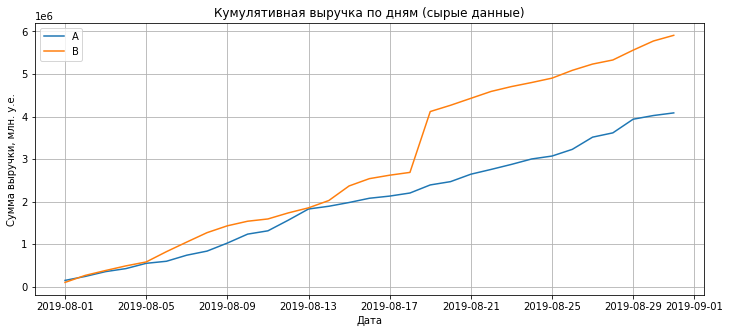

In [25]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cum_revenue_a = cum_data[cum_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cum_revenue_b = cum_data[cum_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.figure(figsize=(12,5))
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue'], label='B')
plt.legend()
plt.title('Кумулятивная выручка по дням (сырые данные)')
plt.xlabel('Дата')
plt.ylabel('Сумма выручки, млн. у.е.')
plt.grid()
plt.show()

Выручка группы А равномерно растет весь период. Выручка группы В практически весь месяц больше, т.е. результат у группы В очевидно лучше, чем у группы А.

Однако в районе 19.08.2019 наблюдаем резкий рост на графике группы В - похоже что как раз сюда попал аномальный заказ стоимостью 1,3 млн. у.е. 

### Кумулятивный средний чек

Построим графики среднего чека для каждой группы:

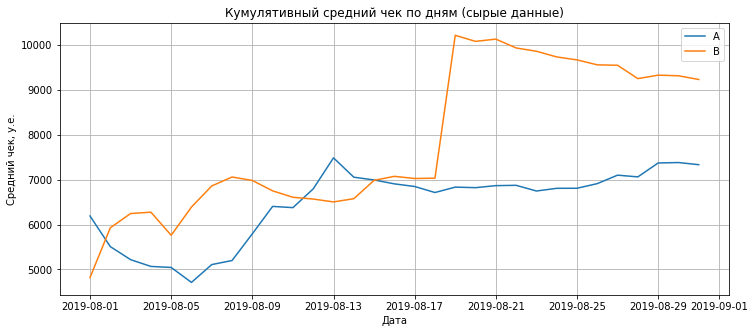

In [26]:
plt.figure(figsize=(12,5))
plt.plot(cum_revenue_a['date'], cum_revenue_a['revenue']/cum_revenue_a['orders'], label='A')
plt.plot(cum_revenue_b['date'], cum_revenue_b['revenue']/cum_revenue_b['orders'], label='B')
plt.legend()
plt.title('Кумулятивный средний чек по дням (сырые данные)')
plt.xlabel('Дата')
plt.ylabel('Средний чек, у.е.')
plt.grid()
plt.show()

Для группы А средний чек стабилизировался во второй половине месяца и после стабилизации был все время ниже среднего чека группы В.

Но следует отметить, что у группы В 19.08.2019 видим резкий рост среднего чека, свидетельствующий об одном или нескольких нетипично крупных заказах. Их влияние к концу периода постепенно снижается, но чтобы "нейтрализовать" такой большой скачок потребуется далеко не один месяц.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

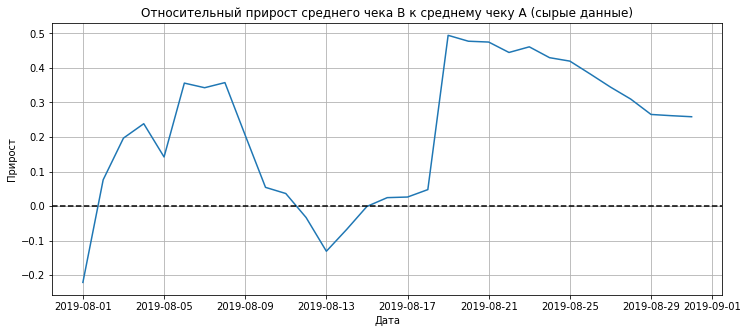

In [27]:
# собираем данные в одном датафрейме
merged_сum_revenue = cum_revenue_a.merge(cum_revenue_b, left_on='date', right_on='date', 
                                         how='left', suffixes=['_A', '_B'])

# cтроим отношение средних чеков
plt.figure(figsize=(12,5))
plt.plot(merged_сum_revenue['date'], 
         (merged_сum_revenue['revenue_B']/merged_сum_revenue['orders_B'])
         /(merged_сum_revenue['revenue_A']/merged_сum_revenue['orders_A'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Относительный прирост среднего чека В к среднему чеку А (сырые данные)')
plt.xlabel('Дата')
plt.ylabel('Прирост')
plt.grid()
plt.show()

БОльшую часть анализируемого периода средний чек группы В был выше среднего чека группы А. Резкие скачки графика  - это влияние выбросов.

### Кумулятивная конверсия

Изучим кумулятивную конверсию:

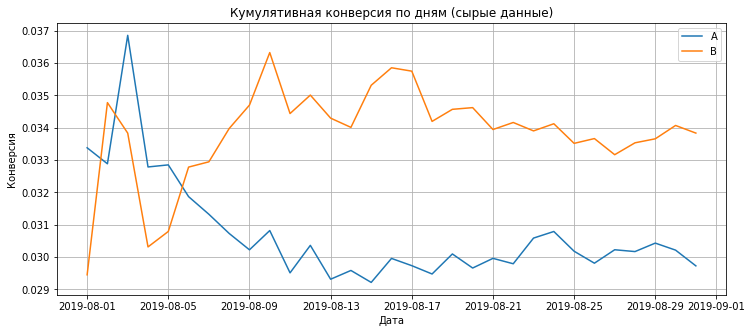

In [28]:
# считаем кумулятивную конверсию
cum_data['conversion'] = cum_data['orders']/cum_data['visitors']

# отделяем данные по группе A
cum_data_a = cum_data[cum_data['group']=='A']

# отделяем данные по группе B
cum_data_b = cum_data[cum_data['group']=='B']

# строим графики
plt.figure(figsize=(12,5))
plt.plot(cum_data_a['date'], cum_data_a['conversion'], label='A')
plt.plot(cum_data_b['date'], cum_data_b['conversion'], label='B')
plt.legend()
plt.title('Кумулятивная конверсия по дням (сырые данные)')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.grid()
plt.show()

Конверсия группы В после 6.08.2019 и до конца месяца была выше, чем конверсия группы А. После 10.08.2019 скачки графиков стали менее резкими, конверсия стабилизировалась. 

Построим график относительного изменения кумулятивной конверсии группы B к группе A:

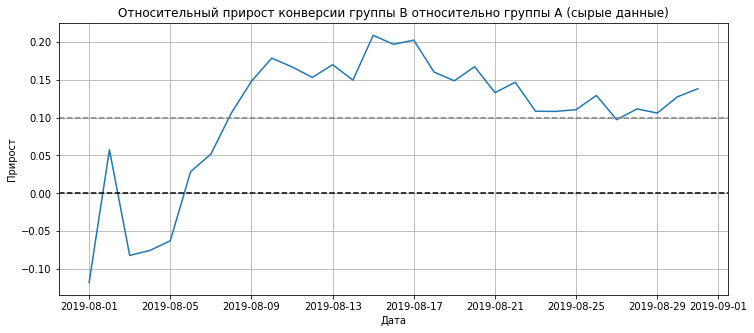

In [29]:
merged_сum_сonversions = cum_data_a[['date','conversion']].merge(
    cum_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B']
)

plt.figure(figsize=(12,5))
plt.plot(merged_сum_сonversions['date'], 
         merged_сum_сonversions['conversion_B']/merged_сum_сonversions['conversion_A']-1
        )
plt.title('Относительный прирост конверсии группы B относительно группы A (сырые данные)')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Прирост')
plt.grid()
plt.show()

Конверсия группы В в последней декаде стабилизировалась на уровне не ниже +10% от конверсии группы А.

### Анализ статистической значимости на основе сырых данных

#### Подготовка данных

Подготовим таблицу, содержащую количество заказов, выручку и количество посещений сайта: 
- за каждый день, 
- нарастающим итогом с начала месяца,
- для каждой группы отдельно

Для этого сформируем отдельные мини-таблицы для каждого показателя, а затем объединим их в общую большую таблицу.

Начнем с количества посещений сайта, которые мы можем взять из таблицы visitors:

In [30]:
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [31]:
# таблица с количеством посещений сайта по дням для группы А
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_A']

# таблица с количеством посещений нарастающим итогом для группы А
visitors_a_cum = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_a_cum.columns = ['date', 'visitors_cum_A']

# таблица с количеством посещений сайта по дням для группы B
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_B']

# таблица с количеством посещений нарастающим итогом для группы B
visitors_b_cum = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_b_cum.columns = ['date', 'visitors_cum_B']

display(visitors_a_daily.head(2), visitors_a_cum.head(2), visitors_b_daily.head(2), visitors_b_cum.head(2))

,date,visitors_per_date_A
0,2019-08-01,719
1,2019-08-02,619


,date,visitors_cum_A
0,2019-08-01,719
1,2019-08-02,1338


,date,visitors_per_date_B
31,2019-08-01,713
32,2019-08-02,581


,date,visitors_cum_B
31,2019-08-01,713
32,2019-08-02,1294


Теперь подготовим таблицы с количеством заказов и выручкой на основе датасета orders:

In [32]:
orders.head(3)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


In [33]:
# таблица с количеством заказов и выручкой по дням для группы А
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# таблица с количеством заказов и выручкой нарастающим итогом для группы А
orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cum.columns = ['date','orders_cum_A','revenue_cum_A']

# таблица с количеством заказов и выручкой по дням для группы B
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# таблица с количеством заказов и выручкой нарастающим итогом для группы B
orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cum.columns = ['date', 'orders_cum_B', 'revenue_cum_B']

display(orders_a_daily.head(2), orders_a_cum.head(2), orders_b_daily.head(2), orders_b_cum.head(2))

,date,orders_per_date_A,revenue_per_date_A
0,2019-08-01,24,148579
1,2019-08-02,20,93822


,date,orders_cum_A,revenue_cum_A
0,2019-08-01,24,148579
1,2019-08-02,44,242401


,date,orders_per_date_B,revenue_per_date_B
0,2019-08-01,21,101217
1,2019-08-02,24,165531


,date,orders_cum_B,revenue_cum_B
0,2019-08-01,21,101217
1,2019-08-02,45,266748


Теперь можем объединить полученные 8 таблиц в одну по датам:

In [34]:
general_data = (
    orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cum, left_on='date', right_on='date', how='left')
    .merge(orders_b_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cum, left_on='date', right_on='date', how='left')
)

general_data.head(3)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cum_A,revenue_cum_A,orders_cum_B,revenue_cum_B,visitors_per_date_A,visitors_per_date_B,visitors_cum_A,visitors_cum_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803


Таблица данных готова, можно считать статистическую значимость.

#### Статистическая значимость различий в конверсии по сырым данным

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

**Нулевая гипотеза**: Конверсии групп А и В распределены одинаково.

**Альтернативная гипотеза**: Конверсии групп А и В имеют разное распределение.

Поскольку распределения количества и стоимости заказов у нас ненормальные (это мы выяснили [здесь](#orders)  и [здесь](#revenue)), то будем использовать непараметрический тест Манна-Уитни.

Подготовим выборки для анализа. Сначала рассчитаем количество заказов для каждого пользователя отдельно по каждой группе:

In [35]:
orders.head(2)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [36]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['user_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['user_id', 'orders']

display('group A', orders_by_users_a.head(2))
display('group B', orders_by_users_b.head(2))

'group A'

,user_id,orders
0,8300375,1
1,11685486,1


'group B'

,user_id,orders
0,5114589,1
1,6958315,1


Теперь нам нужно добавить в полученные таблицы пользователей, которые не сделали ни одного заказа (у которых количество заказов = 0):

In [37]:
alpha = 0.05

sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                general_data['visitors_per_date_A'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                general_data['visitors_per_date_B'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


p_value = stats.mannwhitneyu(sample_a, sample_b)[1]

print('p_value =', "{0:.3f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу, распределение конверсий различается')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, конверсии распределены одинаково')
    

print('Превышение конверсии группы В над конверсией группы А:', 
      "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p_value = 0.017
Отвергаем нулевую гипотезу, распределение конверсий различается
Превышение конверсии группы В над конверсией группы А: 0.138


Первое число (0,017) - это p-value, оно получилось меньше уровня статичстической значимости (0,05). Т.е. вероятность получить такое различие при верной нулевой гипотезе слишком мала (1,7%). Значит, у нас достаточно оснований, чтобы отвергнуть нулевую гипотезу, **конверсии групп А и В различаются**.

Второе число (0,138) показывает нам, что конверсия группы В выше, чем конверсия группы А на 13,8%.

#### Статистическая значимость различий в среднем чеке по сырым данным

Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным.

**Нулевая гипотеза**: Средний чек групп А и В распределен одинаково.

**Альтернативная гипотеза**: Распределения среднего чека групп А и В различаются.

In [38]:
alpha = 0.05

p_value = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]

print('p_value =', "{0:.3f}".format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, распределение среднего чека различается')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, средний чек распределен одинаково')
    

print('Превышение среднего чека группы В над средним чеком группы А:', 
      '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()
                       /orders[orders['group']=='A']['revenue'].mean()-1))

p_value = 0.729
Нет оснований отвергнуть нулевую гипотезу, средний чек распределен одинаково
Превышение среднего чека группы В над средним чеком группы А: 0.259


Получили p-value 0,729, что значительно больше уровня статистической значимости (0,05). У нас нет оснований отвергнуть нулевую гипотезу. **Средние чеки групп А и В распределены одинаково**.

Второе значение (0,259) говорит нам о том, что средний чек группы В выше, чем средний чек группы А на 25,9%. Однако вероятность получить такое различие при верной нулевой гипотезе (т.е. при одинаково распределенных средних чеках групп А и В) - 72,9% Значит, мы не можем делать вывод о значимом различии между средними чеками.

### Анализ статистической значимости по очищенным от аномалий данным

#### Выделение аномальных пользователей

Примем за аномальных пользователей тех, кто совершил [более 4-х покупок](#orders_pers) и заплатил за 1 заказ [более 30 000 у.е.](#revenue_pers) Так мы уберем 1% пользователей с наибольшим числом заказов и чуть меньше 5% пользоватлей с дорогими заказами. 

Узнаем количество таких пользователей:

In [39]:
users_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 4]['user_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 4]['user_id'],
    ],
    axis=0,
)
users_expensive_orders = orders[orders['revenue'] > 30000]['visitor_id']

abnormal_users = (
    pd.concat([users_many_orders, users_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5), abnormal_users.shape)

1099    148427295
928     204675465
684     358944393
648     382846391
1189    393266494
dtype: int64

(53,)

Итак, мы выделили пользователей с количеством заказов более 4х и стоимостью заказов более 30 000 у.е., их оказалось 53 человека. Проверим, как они повлияли на результаты теста.

#### Статистическая значимость различий в конверсии по очищенным данным

Подготовим выборки для анализа с количеством заказов для каждого пользователя в группах:

In [40]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                general_data['visitors_per_date_A'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                general_data['visitors_per_date_B'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [41]:
alpha = 0.05

p_value = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]

print('p_value =', "{0:.3f}".format(p_value))
if p_value < alpha:
    print('Отвергаем нулевую гипотезу, распределение конверсий различается')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, конверсии распределены одинаково')
    

print('Превышение конверсии группы В над конверсией группы А:', 
      "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

p_value = 0.019
Отвергаем нулевую гипотезу, распределение конверсий различается
Превышение конверсии группы В над конверсией группы А: 0.144


Результаты по конверсии практически не изменились: 
- p-value стало 1,9% (было 1,7%), это ниже уровня статистической значимости, отвергаем нулевую гипотезу, конверсии групп А и В различаются;
- конверсия группы В на 14,4% (было на 13,8%) превышает конверсию группы А.

#### Статистическая значимость различий в среднем чеке по очищенным данным

Проверим, произошло ли после очистки что-либо с результатами по среднему чеку:

In [42]:
alpha = 0.05

p_value = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]

print('p_value =', "{0:.3f}".format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу, распределение среднего чека различается')
else:
    print('Нет оснований отвергнуть нулевую гипотезу, средний чек распределен одинаково')
    

print('Превышение среднего чека группы В над средним чеком группы А:', 
      "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p_value = 0.979
Нет оснований отвергнуть нулевую гипотезу, средний чек распределен одинаково
Превышение среднего чека группы В над средним чеком группы А: -0.017


Выводы по результатам теста не изменились.  
Р-value увеличилось с 0,729 до 0,979, это значительно больше уровня статистической значимости 0,05. У нас нет оснований отвергнуть нулевую гипотезу. **Средние чеки групп А и В распределены одинаково**.

Второе значение (было 0,259 стало -0,017) говорит нам о том, что средний чек группы В стал ниже, чем средний чек группы А на 1,7%. Однако вероятность получить такое различие при верной нулевой гипотезе - 97,9%. Значит, мы не можем делать вывод о значимом различии между средними чеками.

### Вывод

<p></p>

<div style="border:solid green 2px; padding: 20px">


После добавления формы подписки на все основные страницы:
    
- количество заказов стало больше, 
- средний чек остался прежним,
- выручка выросла за счет увеличения конверсии.
    
Тест можно останавливать, группа В победила, прирост конверсии составил +14%. 
    
Аномальные заказы повлияли на средний чек и выручку (в сторону увеличения), но не повлияли на конверсию.
 
</div>

## Итоговые выводы

<p></p>

<div style="border:solid green 2px; padding: 20px">

- Для тестирования выбрана гипотеза: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
    
- В августе 2019 года был проведен А/В-тест, в котором участвовал 1031 посетитель интернет-магазина.
    
- За исследуемый период пользователи успели сделать от 1 до 11 заказов. Покупателей, сделавших более 4-х заказов (1%) мы посчитали аномальными.
    
- Стоимость заказов варьировалась от 50 до 1,3 млн. у.е. Заказы стоимостью более 30 тыс. у.е. (это чуть менее 5% заказов) мы посчитали выбросами.
    
- В результате тестирования прирост конверсии группы В составил +14% относительно конверсии группы А. Средний чек не изменился.
    
- Аномальные заказы повлияли на средний чек и выручку (в сторону увеличения), но не повлияли на конверсию.
    
- **Добавление формы подписки на все основные страницы позволит увеличить выручку за счет увеличения конверсии**.   
    
- Необходимо обратить внимание отдела маркетинга на то, что разделение на группы было произвдено некорректно: 58 пользователей (5,6%) попали сразу в обе группы. В дальнейшем такие ошибки следует исключить.

</div>